# Run anomaly detection

In [1]:
# 1. Setup
%pip install -e .. -q
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.


In [1]:
# 2. Load default config
from pathlib import Path

import pandas as pd

from metro_disruptions_intelligence.detect.streaming_iforest import StreamingIForestDetector

project_root = Path.cwd().parent

config_path = project_root / "configs" / "iforest_default.yaml"

**Note:** `StreamingIForestDetector` uses a default `subsample_size` of 256. Running it on fewer observations (like the synthetic example below) will yield zero anomaly scores. For small samples you can pass a custom configuration:
```python
from metro_disruptions_intelligence.detect import IForestConfig
det = StreamingIForestDetector(IForestConfig(subsample_size=50))
```

In [2]:
# 3. Choose processed features root
project_root = Path.cwd().parent
processed_root = project_root / "data" / "stations_features_time_series"

In [5]:
print(processed_root)

c:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence\data\stations_features_time_series


In [3]:
# 4. Stream 2 hours of synthetic data
import json
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np

start = datetime(2023, 5, 1, 0, 0)
rows = []
det = StreamingIForestDetector(config_path)
for i in range(120):
    ts = int((start + timedelta(minutes=i)).timestamp())
    df = pd.DataFrame({
        "snapshot_timestamp": [ts],
        "stop_id": ["100"],
        "direction_id": [0],
        "central_flag": [1],
        "congestion_level": [np.random.rand()],
        "occupancy": [np.random.rand()],
        "node_degree": [2],
        "hub_flag": [0],
    })
    out = det.score_and_update(df, explain=True)
    rows.append(out)
scores = pd.concat(rows, ignore_index=True)

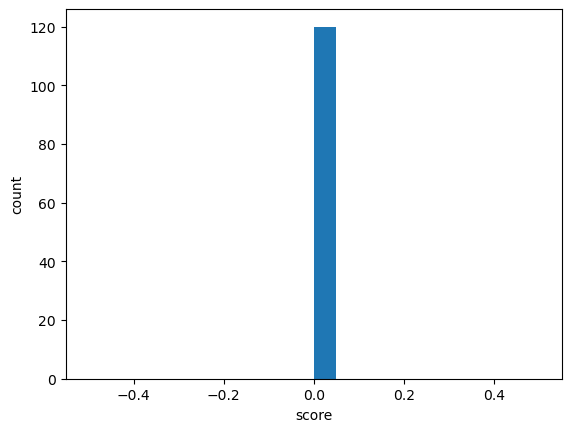

In [4]:
# 5. Histogram of anomaly_score
plt.hist(scores["anomaly_score"], bins=20)
plt.xlabel("score")
plt.ylabel("count");

In [6]:
# 6. Top-10 anomalies with SHAP explanations
top10 = scores.nlargest(10, "anomaly_score").copy()
top10["shap_top3"] = top10["shap_top3_json"].apply(json.loads)
top10[["ts", "stop_id", "anomaly_score", "shap_top3"]]

,ts,stop_id,anomaly_score,shap_top3
0,1682895600,100,0.0,"[[central_flag, 0], [congestion_level, 0], [oc..."
1,1682895660,100,0.0,"[[central_flag, 0], [congestion_level, 0], [oc..."
2,1682895720,100,0.0,"[[central_flag, 0], [congestion_level, 0], [oc..."
3,1682895780,100,0.0,"[[central_flag, 0], [congestion_level, 0], [oc..."
4,1682895840,100,0.0,"[[central_flag, 0], [congestion_level, 0], [oc..."
5,1682895900,100,0.0,"[[central_flag, 0], [congestion_level, 0], [oc..."
6,1682895960,100,0.0,"[[central_flag, 0], [congestion_level, 0], [oc..."
7,1682896020,100,0.0,"[[central_flag, 0], [congestion_level, 0], [oc..."
8,1682896080,100,0.0,"[[central_flag, 0], [congestion_level, 0], [oc..."
9,1682896140,100,0.0,"[[central_flag, 0], [congestion_level, 0], [oc..."


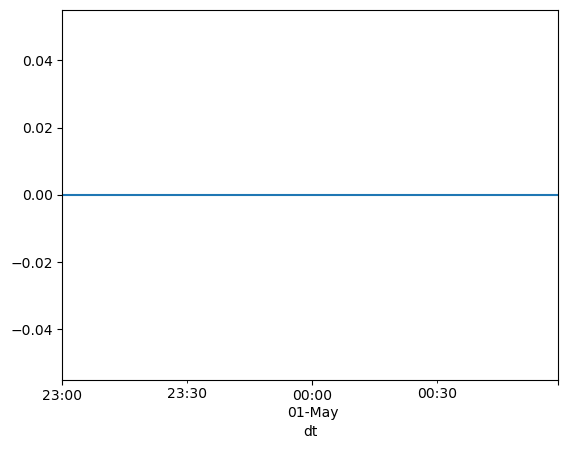

In [7]:
# 7. Mean anomaly_score over time
scores["dt"] = pd.to_datetime(scores["ts"], unit="s")
mean_series = scores.groupby("dt")["anomaly_score"].mean()
mean_series.plot();

In [8]:
# 8. Tune hyper-parameters via CLI
!poetry run mdi tune-iforest \
+        --processed-root data/stations_features_time_series \
+        --start 2023-05-01T00:00:00Z \
+        --end 2023-05-01T02:00:00Z
print(Path("iforest_best.yaml").read_text())

'poetry' is not recognized as an internal or external command,
operable program or batch file.


FileNotFoundError: [Errno 2] No such file or directory: 'iforest_best.yaml'